In [17]:
from datasetup import *

In [24]:
from resnet50 import *

In [30]:
import copy
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

In [63]:
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss Curve")
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()


In [64]:
def eval_plot(y_true, y_pred, class_names=["Healthy", "Unhealthy"]):
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()

    print("Confusion Matrix:\n", conf_matrix)
    print(f"TP: {tp}, FP: {fp}, TN: {tn}, FN: {fn}")

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix Heatmap")
    plt.show()


In [65]:
from sklearn.metrics import roc_curve, auc

def plot_final_roc(model, dataloader):
    model.eval()
    y_true = []
    y_scores = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # get class-1 probs

            y_true.extend(labels.cpu().numpy())
            y_scores.extend(probs.cpu().numpy())

    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlabel("False Positive Rate (1 - Specificity)")
    plt.ylabel("True Positive Rate (Sensitivity)")
    plt.title("Final ROC Curve")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [66]:
def train(model, criterion, optimizer, num_epochs = 1, patience=3, save_path="./best_model.pth"):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_static = 0

    # For plotting
    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(num_epochs):
        for phase in ["train", "test"]:
            if phase == "train":
                model.train()
            else:
                model.eval()
    
            running_loss = 0.0
            running_corrects = 0

            y_true = []
            y_pred = []
    
            for imgs, labels in dataloaders[phase]:
                inputs = imgs.to(device)
                labels = labels.to(device)
    
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

    
                    if phase == "train":
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()
    
                    y_true.extend(labels.cpu().numpy())
                    y_pred.extend(preds.cpu().numpy())
                
                    
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.float() / len(image_datasets[phase])


            if phase == "train":
                history["train_loss"].append(epoch_loss)
                history["train_acc"].append(epoch_acc.item())

            else:
                history["val_loss"].append(epoch_loss)
                history["val_acc"].append(epoch_acc.item())

                conf = confusion_matrix(y_true, y_pred)
                tn, fp, fn, tp = conf.ravel()
                
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    with open(save_path, 'wb') as f:
                        torch.save(model.state_dict(), f)
                    print("best model saved")
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    print(f" No improvement for {epochs_no_improve} epoch(s).")

                if epochs_no_improve >= patience:
                    print("Early stopping")
                    model.load_state_dict(best_model_wts)
                    plot_history(history)
                    return model, history, y_true, y_pred
            print(f"{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}")
    model.load_state_dict(best_model_wts)
    #plot_history(history)
    return model, history, y_true, y_pred



train loss: 0.1030, acc: 0.9480
best model saved
test loss: 0.1026, acc: 0.9564
train loss: 0.0968, acc: 0.9635
 No improvement for 1 epoch(s).
test loss: 0.1115, acc: 0.9551
train loss: 0.1016, acc: 0.9555
best model saved
test loss: 0.1022, acc: 0.9617
train loss: 0.1042, acc: 0.9590
 No improvement for 1 epoch(s).
test loss: 0.1306, acc: 0.9399
train loss: 0.0974, acc: 0.9525
 No improvement for 2 epoch(s).
test loss: 0.1080, acc: 0.9511
train loss: 0.0888, acc: 0.9630
 No improvement for 3 epoch(s).
Early stopping


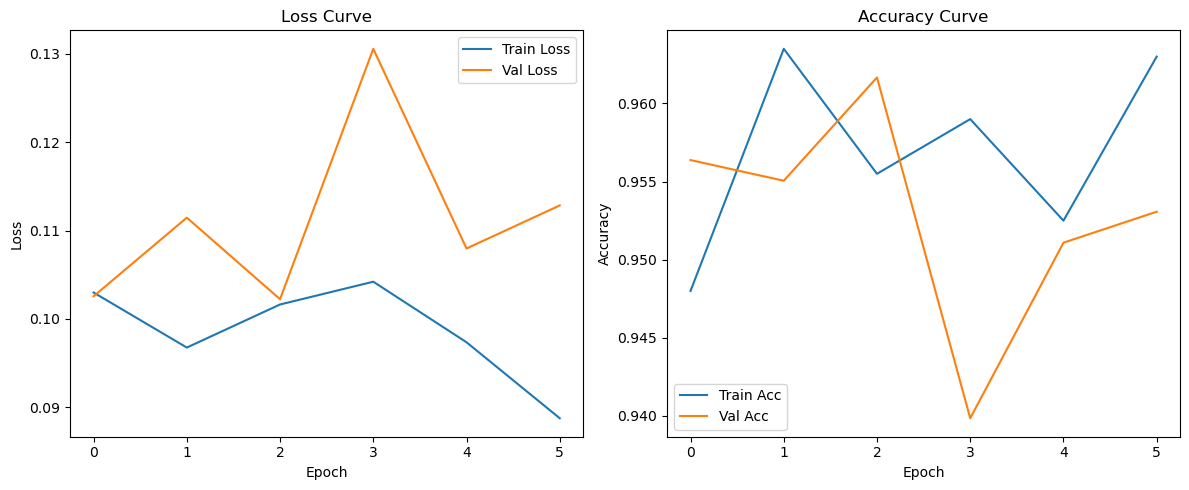

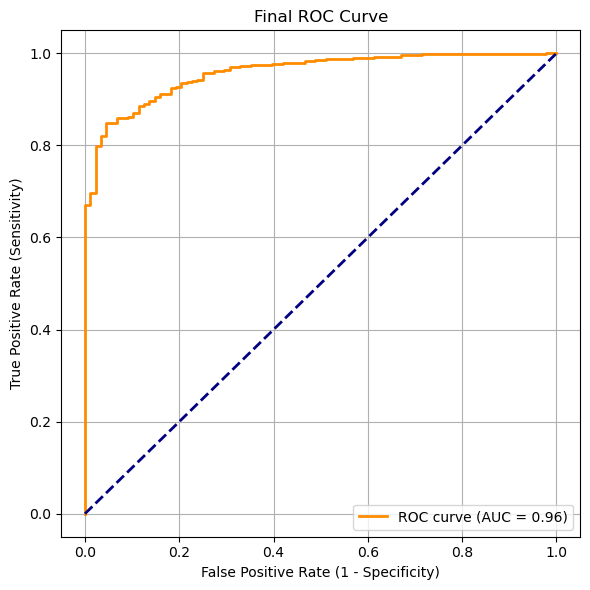

In [67]:
model = model.to(device)
model, history, y_true, y_pred = train(model, criterion, optimizer, num_epochs=10)
#eval_plot(y_true, y_pred)
plot_final_roc(model, dataloaders["test"])